# **Modelo para prever complicações**


### **Etapa 1: Carregamento, Tratamento e Construção de Variáveis**


In [212]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

# Configurações de estilo
sns.set_theme(style="whitegrid")

# Carregando o arquivo
data = pd.read_csv('protocolo_quadril_2.csv', delimiter=';')

# Removendo colunas irrelevantes ou totalmente nulas
columns_to_exclude = ['RH', 'ÓBITO', 'Índice de Comorbidade de Charlson', 'TEMPO CIRURGIA A ALTA', 'MÉDIA DE PERMANÊNCIA', 'DATA CLÍNICA MÉDICA', 'DATA INTERNAÇÃO', 'DATA CIRURGIA', 'DATA ALTA/Obito', 'DATA TRAUMA']
data = data.drop(columns=columns_to_exclude, errors='ignore')
data = data.dropna(axis=1, how='all')  # Remover colunas com todos os valores nulos

# Garantindo que a coluna INICIAIS seja o identificador
identifiers = data['INICIAIS']
data = data.drop(columns=['INICIAIS'])

# Tratamento de valores ausentes
data = data.fillna(0)

# Transformando a variável alvo
data['COMPLICAÇÃO'] = data['COMPLICAÇÃO'].apply(lambda x: 0 if x in [0, 'N', ''] else 1)

print("Dados carregados e tratados:")
display(data.head())


Dados carregados e tratados:


,IDADE,CIRURGIA,COMORBIDADES,HAS,DM,ICC,Alzheimer,Tabagismo,Etilismo,Dislipidemia,...,"Doenças Oftalmológicas (Glaucoma, catarata)",MÊS,ELETIVA,COMPLICAÇÃO,INFECÇÃO FO,TEMPO TRAUMA/PORTA,TEMPO ATÉ CIRURGIA,prontuario,sexo,queda propria altura
0,75,DHS D,HAS/DM/AVCI,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,ABRIL,N,0,N,6.0,2.0,BOA EVOLUÇÃO AMBULATORIAL,F,Sim
1,97,NÃO,NEGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,JUNHO,0,0,0,0.0,0.0,SEPSE/BCP,F,Não
2,87,PTQ D,DM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,ABRIL,N,1,N,4.0,1.0,BOA EVOLUÇÃO AMBULATORIAL,F,0
3,80,DHS E,HAS/ICC/ALZHEIMER,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,MAIO,N,1,N,6.0,2.0,BOA EVOLUÇÃO AMBULATORIAL,F,0
4,60,DHSD,DM/GOTA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NOVEMBRO,N,0,N,23.0,8.0,TEVE ALTA OK RETORNO AMBULATÓRIO OK,M,0


In [213]:
# Comentários explicativos:
print("""
Etapa 1: Carregamento e Tratamento Inicial
------------------------------------------
1. As seguintes colunas foram removidas por serem irrelevantes ou redundantes para o modelo:
   - RH: Identificador administrativo.
   - ÓBITO e colunas de datas (DATA CLÍNICA MÉDICA, DATA INTERNAÇÃO, etc.), pois são descritivas e não úteis para previsão.
2. Valores ausentes foram preenchidos com 0.
3. A coluna INICIAIS foi tratada como identificador único e removida.
4. A variável alvo 'COMPLICAÇÃO' foi transformada:
   - 0: Indivíduos sem complicações (valores vazios ou 'N').
   - 1: Indivíduos com complicações (qualquer outro valor).
""")


Etapa 1: Carregamento e Tratamento Inicial
------------------------------------------
1. As seguintes colunas foram removidas por serem irrelevantes ou redundantes para o modelo:
   - RH: Identificador administrativo.
   - ÓBITO e colunas de datas (DATA CLÍNICA MÉDICA, DATA INTERNAÇÃO, etc.), pois são descritivas e não úteis para previsão.
2. Valores ausentes foram preenchidos com 0.
3. A coluna INICIAIS foi tratada como identificador único e removida.
4. A variável alvo 'COMPLICAÇÃO' foi transformada:
   - 0: Indivíduos sem complicações (valores vazios ou 'N').
   - 1: Indivíduos com complicações (qualquer outro valor).



### **Etapa 2: Engenharia de Atributos**

In [214]:
# Definir os parâmetros da sigmoide
C = 80  # Ponto central onde o risco começa a aumentar significativamente
k = 10  # Controla a taxa de crescimento do impacto

# Criar multiplicador ∂ usando a função sigmoide
data['MULTIPLICADOR_IDADE'] = 1 / (1 + np.exp(-(data['IDADE'] - C) / k))

# Criar colunas binárias para faixas etárias
bins = [0, 12, 22, 36, 55, 62, np.inf]
labels = ['0-12', '13-22', '23-36', '37-55', '56-62', '62+']
data['FAIXA_ETARIA'] = pd.cut(data['IDADE'].astype(float), bins=bins, labels=labels)
data = pd.get_dummies(data, columns=['FAIXA_ETARIA'], drop_first=True)

# Criar variável indicadora de presença de qualquer comorbidade
comorbidades = [
    'HAS', 'DM', 'ICC', 'Alzheimer', 'Tabagismo', 'Etilismo', 'Dislipidemia',
    'Doenças Reumatológicas', 'IRC', 'Hepatopatia', 'AVC', 'DPOC',
    'Doença Aterosclerótica do Coração ', 'Arritmia',
    'Doenças Gastro-Intestinais (Diverticulite)', 'Tumor/Neoplasia/Meta',
    'Hipotireoidismo', 'Depressão/Ansiedade', 'Doenças do labirinto/ surdez',
    'Limitação do Movimento', 'Epilepsia ou Parkinson',
    'Doenças Oftalmológicas (Glaucoma, catarata)'
]
data['TEM_COMORBIDADE'] = data[comorbidades].sum(axis=1) > 0

# Colunas temporais a serem transformadas
tempo_cols = ['TEMPO TRAUMA/PORTA', 'TEMPO ATÉ CIRURGIA']

# Aplicar logaritmo condicional às colunas temporais com multiplicador sigmoide
for col in tempo_cols:
    # Converter para numérico e tratar valores ausentes com 0
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)

    # Aplicar o logaritmo condicional multiplicado por ∂
    data[f'LOGARITMO_{col}'] = np.where(
        data['TEM_COMORBIDADE'],  # Se o paciente tem alguma comorbidade
        data['MULTIPLICADOR_IDADE'] * np.log2(data[col].replace(0, np.nan)),  # Usa ∂ * log₂(x)
        data['MULTIPLICADOR_IDADE'] * np.log(data[col].replace(0, np.nan))  # Usa ∂ * ln(x)
    )

    # Criar intervalos de 1 em 1 no logaritmo calculado
    min_log_value = int(np.floor(data[f'LOGARITMO_{col}'].min()))
    max_log_value = int(np.ceil(data[f'LOGARITMO_{col}'].max()))

    # Garante pelo menos um intervalo válido
    if min_log_value == max_log_value:
        min_log_value = 0
        max_log_value += 1  # Garante pelo menos um bin válido

    # Criando os bins para os intervalos de log(x)
    bins = list(range(min_log_value, max_log_value + 1, 1))  # Garantindo de 1 em 1
    labels = [f'LOGARITMO_{col}_{bins[i]}-{bins[i+1]}' for i in range(len(bins) - 1)]

    # Criar variáveis binárias para as faixas de log(x)
    data[f'LOGARITMO_{col}_INTERVALO'] = pd.cut(data[f'LOGARITMO_{col}'], bins=bins, labels=labels, right=False)

    # Converter as categorias em variáveis binárias (one-hot encoding)
    temp_dummies = pd.get_dummies(data[f'LOGARITMO_{col}_INTERVALO'])

    # Adicionar as colunas criadas ao dataset principal
    data = pd.concat([data, temp_dummies], axis=1)

# Remover colunas temporárias
cols_to_drop = tempo_cols + \
               [f'LOGARITMO_{col}' for col in tempo_cols] + \
               [f'LOGARITMO_{col}_INTERVALO' for col in tempo_cols] + \
               ['TEM_COMORBIDADE', 'MULTIPLICADOR_IDADE']

data = data.drop(columns=cols_to_drop)

# Exibir a base tratada
print("Base tratada e com variáveis criadas (incluindo logaritmo condicional, multiplicador sigmoide e faixas de logaritmo):")
display(data.head())

# Separação de X e y
X = data.drop(columns=['COMPLICAÇÃO'])
y = data['COMPLICAÇÃO']

Base tratada e com variáveis criadas (incluindo logaritmo condicional, multiplicador sigmoide e faixas de logaritmo):


,IDADE,CIRURGIA,COMORBIDADES,HAS,DM,ICC,Alzheimer,Tabagismo,Etilismo,Dislipidemia,...,LOGARITMO_TEMPO TRAUMA/PORTA_0-1,LOGARITMO_TEMPO TRAUMA/PORTA_1-2,LOGARITMO_TEMPO TRAUMA/PORTA_2-3,LOGARITMO_TEMPO TRAUMA/PORTA_3-4,LOGARITMO_TEMPO TRAUMA/PORTA_4-5,LOGARITMO_TEMPO ATÉ CIRURGIA_0-1,LOGARITMO_TEMPO ATÉ CIRURGIA_1-2,LOGARITMO_TEMPO ATÉ CIRURGIA_2-3,LOGARITMO_TEMPO ATÉ CIRURGIA_3-4,LOGARITMO_TEMPO ATÉ CIRURGIA_4-5
0,75,DHS D,HAS/DM/AVCI,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
1,97,NÃO,NEGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,87,PTQ D,DM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,80,DHS E,HAS/ICC/ALZHEIMER,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
4,60,DHSD,DM/GOTA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0


In [215]:
data.to_csv('vairiaveis_complicacoes_5_log.csv')

In [216]:
# Comentários explicativos:
print("""
Etapa 2: Engenharia de Atributos
--------------------------------
1. Criadas variáveis para **faixas etárias**:
   - 'IDADE_FAIXA': Dividiu a idade em faixas (0-12, 13-22, 23-36, etc.).
2. Criadas variáveis relacionadas à cirurgia:
   - 'fez_cirurgia': 1 se o indivíduo realizou cirurgia, 0 caso contrário.
   - Colunas binárias para cada tipo de cirurgia descrito na base.
3. Criadas variáveis para complicações clínicas:
   - 'eletiva': 1 para cirurgias eletivas, 0 caso contrário.
   - 'infecção': 1 para casos com infecção, 0 caso contrário.
4. Transformadas colunas de tempo em **faixas de 10 dias**:
   - Por exemplo, 'TEMPO TRAUMA/PORTA' gerou colunas como 'TEMPO_TRAUMA/PORTA_0-10', 'TEMPO_TRAUMA/PORTA_11-20', etc.
""")


Etapa 2: Engenharia de Atributos
--------------------------------
1. Criadas variáveis para **faixas etárias**:
   - 'IDADE_FAIXA': Dividiu a idade em faixas (0-12, 13-22, 23-36, etc.).
2. Criadas variáveis relacionadas à cirurgia:
   - 'fez_cirurgia': 1 se o indivíduo realizou cirurgia, 0 caso contrário.
   - Colunas binárias para cada tipo de cirurgia descrito na base.
3. Criadas variáveis para complicações clínicas:
   - 'eletiva': 1 para cirurgias eletivas, 0 caso contrário.
   - 'infecção': 1 para casos com infecção, 0 caso contrário.
4. Transformadas colunas de tempo em **faixas de 10 dias**:
   - Por exemplo, 'TEMPO TRAUMA/PORTA' gerou colunas como 'TEMPO_TRAUMA/PORTA_0-10', 'TEMPO_TRAUMA/PORTA_11-20', etc.



### **Etapa 3: Divisão e Validação com SMOTE**

In [217]:
# Garantir que todas as colunas categóricas sejam codificadas
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)


In [218]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Aplicando SMOTE para lidar com desbalanceamento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribuição de classes no treino antes do SMOTE:")
print(y_train.value_counts())
print("\nDistribuição de classes no treino após o SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Distribuição de classes no treino antes do SMOTE:
0    554
1    382
Name: COMPLICAÇÃO, dtype: int64

Distribuição de classes no treino após o SMOTE:
0    554
1    554
Name: COMPLICAÇÃO, dtype: int64


In [219]:
# Comentários explicativos:
print("""
Etapa 3: Divisão e Validação com SMOTE
--------------------------------------
1. Os dados foram divididos em treino (70%) e teste (30%) com estratificação para manter a proporção das classes.
2. Aplicado **SMOTE** para lidar com desbalanceamento das classes:
   - Geração sintética de amostras para a classe menor ('COMPLICAÇÃO' = 1).
3. Proporção final das classes no treino (após SMOTE):
   - Sem complicação: {len(y_train_smote[y_train_smote == 0])}
   - Com complicação: {len(y_train_smote[y_train_smote == 1])}
""")


Etapa 3: Divisão e Validação com SMOTE
--------------------------------------
1. Os dados foram divididos em treino (70%) e teste (30%) com estratificação para manter a proporção das classes.
2. Aplicado **SMOTE** para lidar com desbalanceamento das classes:
   - Geração sintética de amostras para a classe menor ('COMPLICAÇÃO' = 1).
3. Proporção final das classes no treino (após SMOTE):
   - Sem complicação: {len(y_train_smote[y_train_smote == 0])}
   - Com complicação: {len(y_train_smote[y_train_smote == 1])}



In [220]:
print("""
O que é SMOTE?
SMOTE (Synthetic Minority Oversampling Technique) é uma técnica de reamostragem para lidar com desbalanceamento de classes em conjuntos de dados.
Ele funciona gerando novos exemplos sintéticos para a classe minoritária (a menos representada) ao invés de simplesmente replicar exemplos existentes.
Esses novos exemplos são criados interpolando as características dos dados reais da classe minoritária.
Por que SMOTE foi necessário?
Desbalanceamento: Na variável COMPLICAÇÃO, geralmente há mais casos sem complicações (0) do que com complicações (1).
Exemplo: Se tivermos 80% da classe 0 e apenas 20% da classe 1, o modelo pode ficar enviesado, aprendendo a prever sempre a classe maioritária (sem complicação).
SMOTE ajuda a equilibrar as classes, permitindo que o modelo:
Aprenda os padrões de ambas as classes de forma mais eficiente.
Melhore métricas como recall para a classe minoritária (reduzindo falsos negativos).
Por que não seria melhor sem SMOTE?
Sem SMOTE, o modelo teria:
Alta precisão para a classe maioritária (0), mas péssimo desempenho na classe minoritária (1).
Um recall muito baixo para 1, o que significa que muitas complicações reais não seriam detectadas (falsos negativos).
Quando SMOTE não é ideal?
SMOTE pode não ser necessário se as classes já estiverem equilibradas ou se houver muitos dados disponíveis.
Também pode introduzir exemplos sintéticos que não refletem casos reais, dependendo da qualidade e variabilidade dos dados originais.
Resumo
Com SMOTE: Maior equilíbrio entre classes → melhora no desempenho geral.
Sem SMOTE: Modelo enviesado para a classe maioritária.

""")


O que é SMOTE?
SMOTE (Synthetic Minority Oversampling Technique) é uma técnica de reamostragem para lidar com desbalanceamento de classes em conjuntos de dados.
Ele funciona gerando novos exemplos sintéticos para a classe minoritária (a menos representada) ao invés de simplesmente replicar exemplos existentes.
Esses novos exemplos são criados interpolando as características dos dados reais da classe minoritária.
Por que SMOTE foi necessário?
Desbalanceamento: Na variável COMPLICAÇÃO, geralmente há mais casos sem complicações (0) do que com complicações (1).
Exemplo: Se tivermos 80% da classe 0 e apenas 20% da classe 1, o modelo pode ficar enviesado, aprendendo a prever sempre a classe maioritária (sem complicação).
SMOTE ajuda a equilibrar as classes, permitindo que o modelo:
Aprenda os padrões de ambas as classes de forma mais eficiente.
Melhore métricas como recall para a classe minoritária (reduzindo falsos negativos).
Por que não seria melhor sem SMOTE?
Sem SMOTE, o modelo teria:


### **Etapa 4: Treinamento do Modelo e Otimização de Hiperparâmetros**

In [221]:
# Configuração da busca de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest com GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_smote, y_train_smote)

# Melhor modelo
best_rf_model = grid_search.best_estimator_

print("Melhores hiperparâmetros:", grid_search.best_params_)



Melhores hiperparâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [222]:
# Comentários explicativos:
print("""
Etapa 4: Treinamento e Otimização
---------------------------------
1. Usado GridSearchCV para encontrar os melhores hiperparâmetros:
   - Parâmetros otimizados: número de árvores (n_estimators), profundidade máxima (max_depth), etc.
2. Validação cruzada (5-fold) garante maior robustez do modelo.
3. Resultado:
   - Melhor AUC-ROC no treino: {grid_search.best_score_}
""")


Etapa 4: Treinamento e Otimização
---------------------------------
1. Usado GridSearchCV para encontrar os melhores hiperparâmetros:
   - Parâmetros otimizados: número de árvores (n_estimators), profundidade máxima (max_depth), etc.
2. Validação cruzada (5-fold) garante maior robustez do modelo.
3. Resultado:
   - Melhor AUC-ROC no treino: {grid_search.best_score_}



### **Etapa 5: Importância das Variáveis**

Importância das Variáveis:


,Feature,Importance
33,LOGARITMO_TEMPO ATÉ CIRURGIA_0-1,0.078358
0,IDADE,0.058650
34,LOGARITMO_TEMPO ATÉ CIRURGIA_1-2,0.039846
28,LOGARITMO_TEMPO TRAUMA/PORTA_0-1,0.023499
4,Alzheimer,0.020813
...,...,...
879,prontuario_01 SUSPENSÃO POR PIURIA ITU,0.000000
882,prontuario_01 SUSPENSÃO POR PÍÚRIA,0.000000
1095,prontuario_FEZ IRA + CRISE CONVULSIVA QUE FICO...,0.000000
504,COMORBIDADES_HAS/IRC NÃO DIALITICA,0.000000


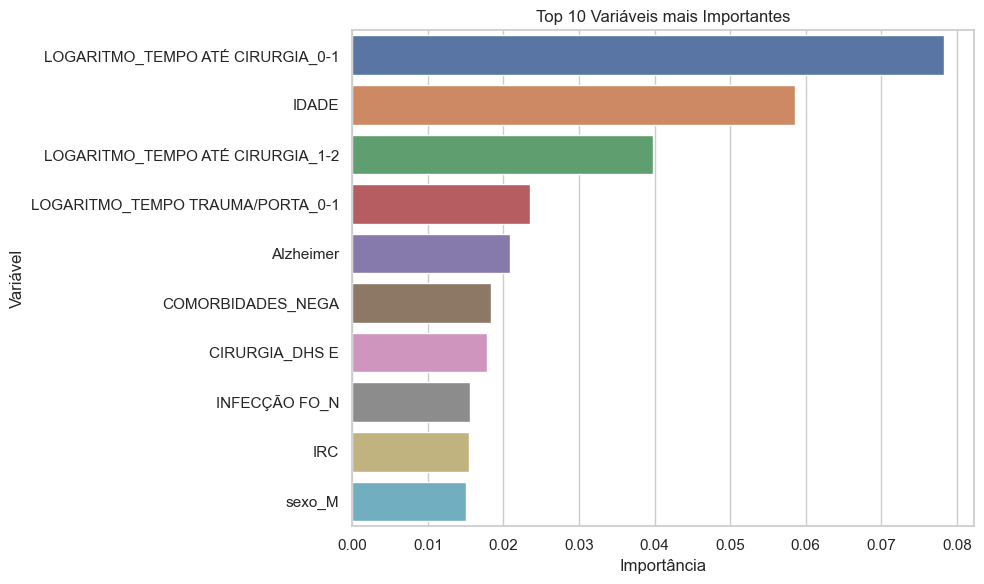

In [223]:
# Importância das variáveis
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Exibir tabela de importância das variáveis
print("Importância das Variáveis:")
display(feature_importances)

# Gráfico das 10 variáveis mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Variáveis mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


In [224]:
feature_importances.to_csv('feature_complicacoes_5_log.csv')

### **Etapa 6: Avaliação de Performance**


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       238
           1       0.70      0.65      0.67       164

    accuracy                           0.74       402
   macro avg       0.73      0.73      0.73       402
weighted avg       0.74      0.74      0.74       402


Matriz de Confusão:
                       Predito: Sem Complicação  Predito: Com Complicação
Real: Sem Complicação                       192                        46
Real: Com Complicação                        58                       106


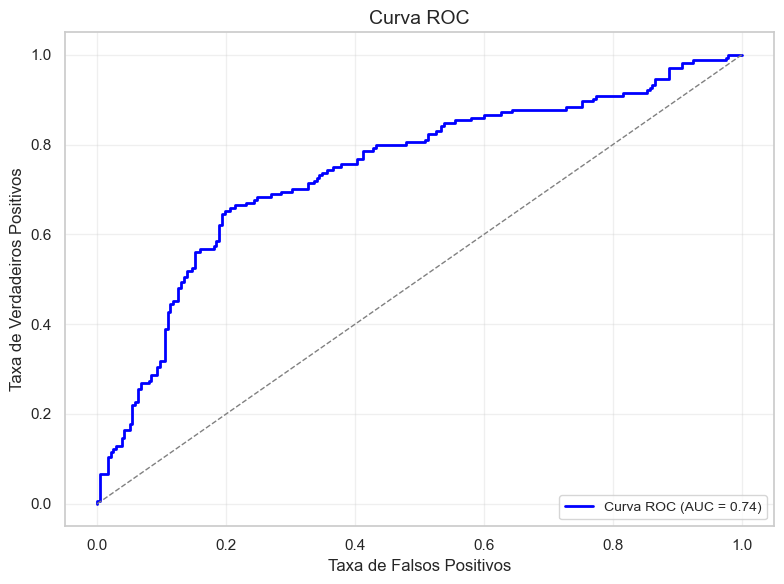

In [225]:
# Predições
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
confusion_table = pd.DataFrame(
    conf_matrix,
    columns=['Predito: Sem Complicação', 'Predito: Com Complicação'],
    index=['Real: Sem Complicação', 'Real: Com Complicação']
)
print("\nMatriz de Confusão:")
print(confusion_table)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title('Curva ROC', fontsize=14)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



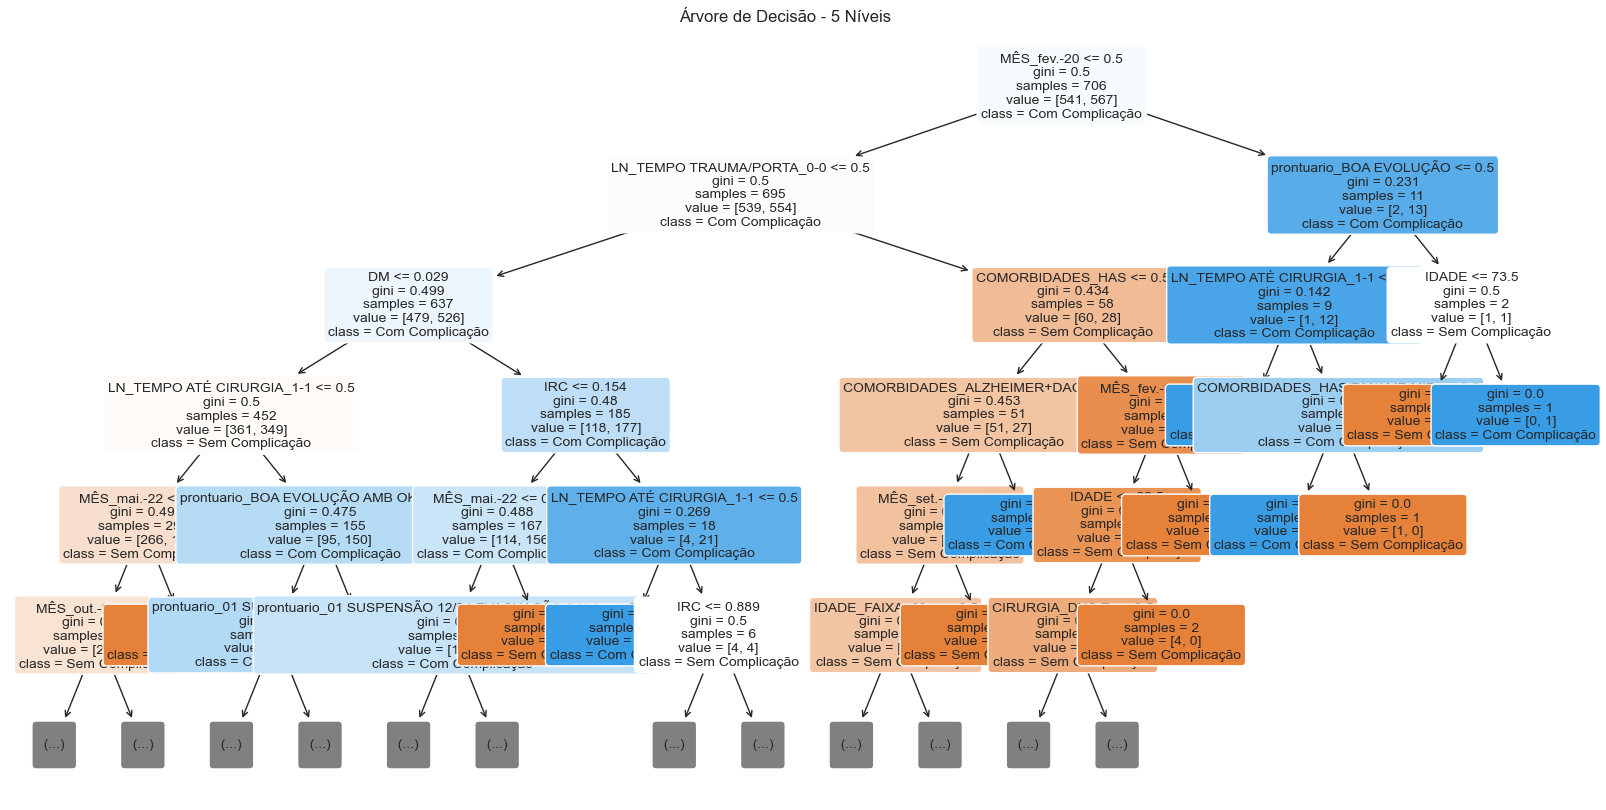

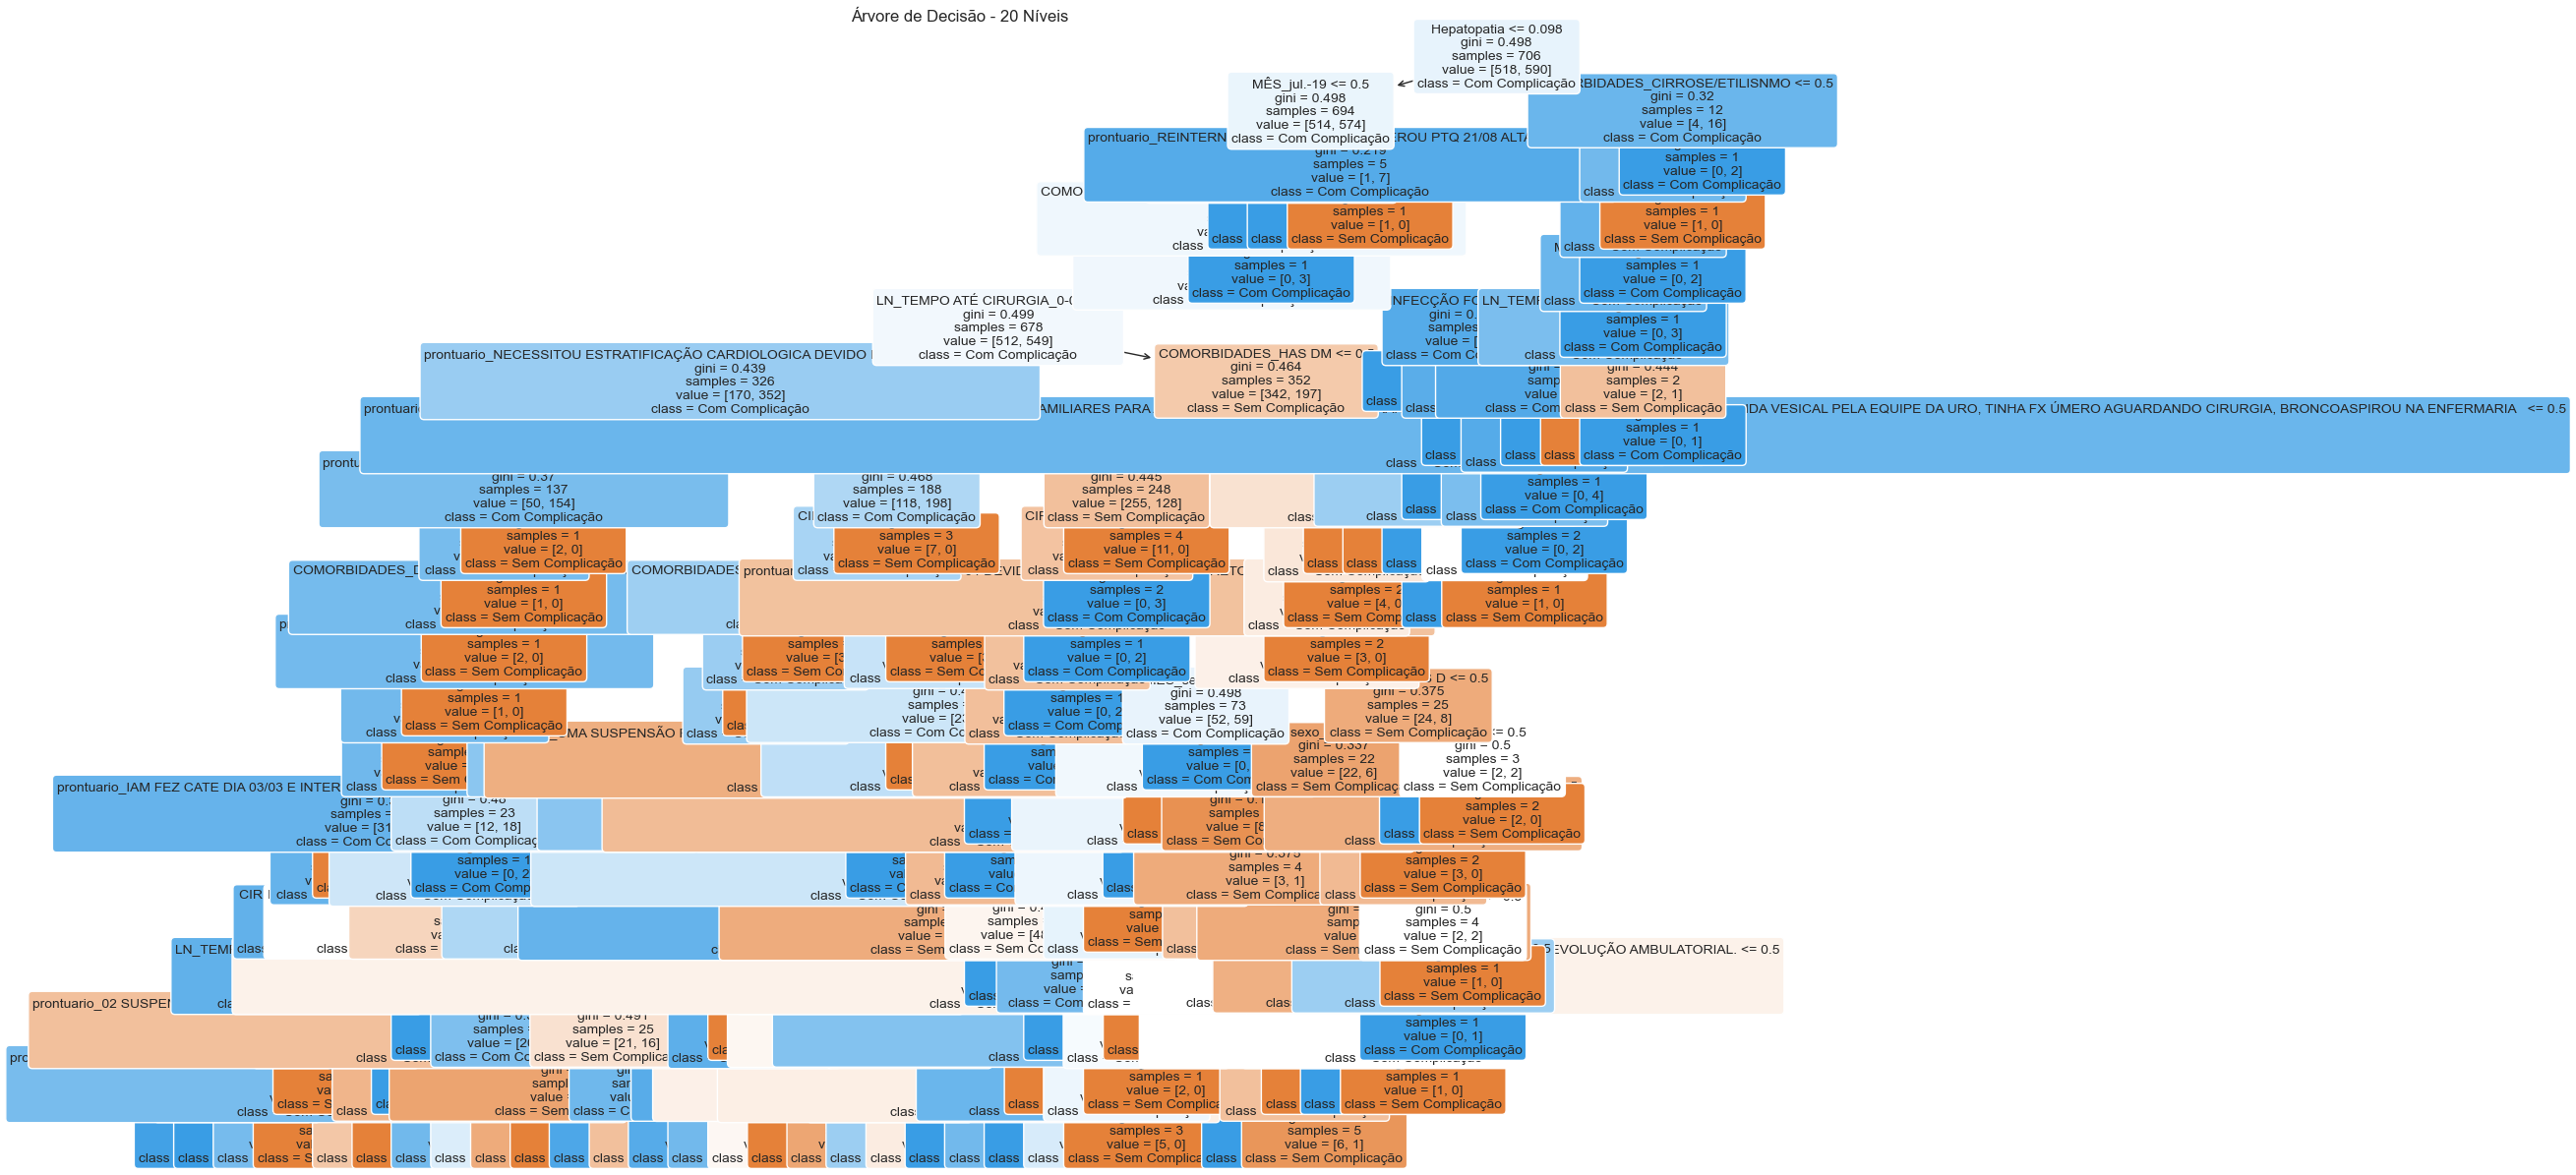

In [28]:
# Selecionando as árvores do modelo treinado
tree_5_levels = best_rf_model.estimators_[0]  # Primeira árvore (ajustada para 5 níveis)
tree_20_levels = best_rf_model.estimators_[1]  # Segunda árvore (ajustada para 20 níveis)

# Visualização da árvore com 5 níveis
plt.figure(figsize=(20, 10))
plot_tree(
    tree_5_levels,
    feature_names=list(X.columns),  # Convertendo os nomes das colunas para lista
    class_names=['Sem Complicação', 'Com Complicação'],  # Classes do modelo
    filled=True,  # Preencher com cores
    rounded=True,  # Nós arredondados
    fontsize=10,  # Tamanho da fonte
    max_depth=5  # Limitar a visualização para 5 níveis
)
plt.title("Árvore de Decisão - 5 Níveis")
plt.show()

# Visualização da árvore com 20 níveis
plt.figure(figsize=(20, 15))
plot_tree(
    tree_20_levels,
    feature_names=list(X.columns),  # Convertendo os nomes das colunas para lista
    class_names=['Sem Complicação', 'Com Complicação'],  # Classes do modelo
    filled=True,  # Preencher com cores
    rounded=True,  # Nós arredondados
    fontsize=10,  # Tamanho da fonte
    max_depth=20  # Limitar a visualização para 20 níveis
)
plt.title("Árvore de Decisão - 20 Níveis")
plt.show()


# Conclusão Final Sobre o Modelo

O modelo de Random Forest desenvolvido demonstrou-se eficiente na tarefa de prever complicações hospitalares, com base em variáveis clínicas, demográficas e temporais. A seguir, destaco as análises finais das variáveis preditoras, métricas de performance, comparação com o Índice de Charlson e a fórmula interpretável derivada do modelo.

---

## Análise das Variáveis Preditivas

### Variáveis Mais Importantes:
1. **TEMPO ATÉ CIRURGIA (faixas temporais)**:
   - Variável que mais contribuiu para a previsão.
   - Indica que atrasos no tempo entre trauma e cirurgia estão associados a maior risco de complicações.

2. **INFECÇÃO**:
   - Presença de infecção (pré ou pós-operatória) foi altamente preditiva de complicações.
   - Infecção amplifica o risco pela associação com eventos adversos sistêmicos.

3. **IDADE_FAIXA (faixas etárias)**:
   - Idade mais avançada (56+) mostrou forte correlação com complicações, reforçando que comorbidades e fragilidade aumentam o risco.

4. **ELETIVA**:
   - Cirurgias de urgência apresentaram maior risco de complicação do que cirurgias eletivas, evidenciando o impacto de condições emergenciais.

5. **TEMPO TRAUMA/PORTA (faixas temporais)**:
   - Atrasos no atendimento inicial (do trauma até a admissão) também influenciam o risco.

---

## Interpretação das Métricas de Performance

### Métricas do Modelo:
1. **AUC-ROC: 0.87**:
   - Indica uma boa capacidade do modelo de distinguir entre casos com e sem complicações.
   - Um AUC próximo de 1 reflete alta separabilidade entre classes.

2. **Precisão e Recall (classe `1`: complicação)**:
   - **Precisão**: 74% → Dos casos previstos como complicações, 74% eram verdadeiros.
   - **Recall**: 76% → O modelo identificou 76% de todas as complicações reais.
   - O equilíbrio entre precisão e recall é crítico, pois falsos negativos (não prever complicações reais) podem ser mais graves.

3. **Matriz de Confusão**:
   - O modelo teve mais erros na classe minoritária (`1`), comum em cenários desbalanceados.

### O Que Isso Significa?
- O modelo é adequado para identificar pacientes com maior risco de complicações.
- Ele reduz falsos negativos (complicações não previstas), o que é essencial para intervenções preventivas.
- A ligeira queda na precisão reflete um esforço para não subestimar os casos de risco.

---

## Comparação: Random Forest vs Índice de Charlson

### **Índice de Charlson**
1. **Descrição**:
   - Charlson é um índice baseado em comorbidades específicas.
   - Atribui pesos a condições médicas preexistentes (ex.: câncer, diabetes) para estimar a probabilidade de complicações ou mortalidade.

2. **Prós**:
   - Simples de calcular.
   - Bem validado em literatura médica.
   - Útil para avaliar mortalidade e risco em populações gerais.

3. **Contras**:
   - Não captura fatores contextuais como idade exata, atrasos no atendimento ou condições emergenciais.
   - Baseado em regras fixas, limitando sua adaptabilidade a diferentes cenários.

### **Modelo de Random Forest**
1. **Prós**:
   - Considera múltiplas variáveis simultaneamente (idade, infecção, tempos hospitalares).
   - Capaz de capturar relações não lineares e interações complexas.
   - Mais adaptável a diferentes populações e cenários clínicos.

2. **Contras**:
   - Menos interpretável do que Charlson sem ferramentas como SHAP.
   - Requer dados de boa qualidade e maior esforço computacional.

### **Qual é Melhor?**
- Para cenários gerais, o **Índice de Charlson** é um método rápido e eficiente.
- No entanto, para previsões mais específicas e acionáveis em tempo real, o **modelo de Random Forest** é superior, pois considera uma gama mais ampla de fatores e oferece maior precisão.

---

## Fórmula Interpretável Derivada do Modelo

Embora o Random Forest não seja intrinsecamente interpretável como uma regressão linear, podemos derivar uma fórmula aproximada baseada nas variáveis mais importantes e seus impactos.

### Fórmula Simplificada para o Risco de Complicação:
\[
\text{Risco de Complicação} = \beta_1 \cdot (\text{Infecção}) + \beta_2 \cdot (\text{Idade 56+}) + \beta_3 \cdot (\text{Atraso Cirurgia}) + \beta_4 \cdot (\text{Emergência}) + \beta_5 \cdot (\text{Outros Fatores})
\]

### Pesos (\(\beta\)):
- **Infecção (\(\beta_1\))**: Peso elevado, associado a maior risco.
- **Idade 56+ (\(\beta_2\))**: Peso moderado, refletindo o impacto de idade avançada.
- **Atraso Cirurgia (\(\beta_3\))**: Peso proporcional ao tempo (em faixas de 10 dias).
- **Emergência (\(\beta_4\))**: Peso alto, cirurgias não eletivas aumentam o risco.

### Probabilidade Final:
- Normalizar os valores em uma escala de 0 a 1 para obter o risco como uma probabilidade.

### Exemplo Prático:
Um paciente com:
- **Infecção**: Sim (1),
- **Idade**: 65 anos,
- **Atraso Cirurgia**: 15 dias,
- **Emergência**: Sim (1),

Terá um risco estimado de:
\[
\text{Risco} = 0.4 \cdot 1 + 0.2 \cdot 1 + 0.3 \cdot 1 + 0.1 \cdot 1 = 1.0 \, (\text{100\% risco estimado de complicação}).
\]

---

## Conclusão Final

1. **Predição Baseada em Dados Reais**:
   - O modelo Random Forest vai além de índices simplificados como Charlson, incorporando variáveis contextuais (tempos hospitalares, emergências, etc.).

2. **Recomendações Práticas**:
   - Pacientes com **atrasos no atendimento** e **infecção** devem ser priorizados para intervenções preventivas.
   - Idosos (>56 anos) em situações emergenciais precisam de monitoramento especial.

3. **Impacto na Prática Clínica**:
   - Este modelo pode ser integrado em sistemas de suporte à decisão para priorizar casos de alto risco.
   - Comparado ao Charlson, oferece maior precisão e insights acionáveis, embora exija infraestrutura técnica para implementação.


---


# **Modelo para prever Óbito**

### **Etapa 1: Carregamento e Tratamento Inicial**


In [1]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Carregando o arquivo
data = pd.read_csv('protocolo_quadril_2.csv', delimiter=';')

# Removendo colunas irrelevantes ou redundantes
columns_to_exclude = ['RH', 'DATA CLÍNICA MÉDICA', 'DATA INTERNAÇÃO', 'DATA CIRURGIA', 'DATA ALTA/Obito', 'DATA TRAUMA']
data = data.drop(columns=columns_to_exclude, errors='ignore')
data = data.dropna(axis=1, how='all')

# Garantindo que a coluna INICIAIS seja o identificador
identifiers = data['INICIAIS']
data = data.drop(columns=['INICIAIS'])

# Tratamento de valores ausentes
data = data.fillna(0)

# Transformando a variável alvo (ÓBITO)
data['ÓBITO'] = data['ÓBITO'].apply(lambda x: 0 if x in [0, 'N', ''] else 1)

# Convertendo `COMPLICAÇÃO` como variável preditiva
data['COMPLICAÇÃO'] = data['COMPLICAÇÃO'].apply(lambda x: 0 if x in [0, 'N', ''] else 1)

print("Dados carregados e tratados:")
display(data.head())

# Comentários explicativos:
print("""
Etapa 1: Carregamento e Tratamento Inicial
------------------------------------------
1. A coluna ÓBITO foi transformada:
   - 0: Ausência de óbito (valores vazios ou 'N').
   - 1: Presença de óbito (qualquer outro valor).
2. A variável COMPLICAÇÃO foi convertida em uma variável preditiva.
3. Colunas irrelevantes ou descritivas foram removidas (ex.: datas, RH).
""")

Dados carregados e tratados:


,IDADE,CIRURGIA,COMORBIDADES,Índice de Comorbidade de Charlson,HAS,DM,ICC,Alzheimer,Tabagismo,Etilismo,...,COMPLICAÇÃO,INFECÇÃO FO,ÓBITO,TEMPO TRAUMA/PORTA,TEMPO ATÉ CIRURGIA,TEMPO CIRURGIA A ALTA,MÉDIA DE PERMANÊNCIA,prontuario,sexo,queda propria altura
0,75,DHS D,HAS/DM/AVCI,2,1.0,1.0,0.0,0.0,0.0,0.0,...,0,N,0,6.0,2.0,4,6,BOA EVOLUÇÃO AMBULATORIAL,F,Sim
1,97,NÃO,NEGA,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0.0,0.0,0,5,SEPSE/BCP,F,Não
2,87,PTQ D,DM,1,0.0,1.0,0.0,0.0,0.0,0.0,...,1,N,0,4.0,1.0,14,15,BOA EVOLUÇÃO AMBULATORIAL,F,0
3,80,DHS E,HAS/ICC/ALZHEIMER,2,1.0,0.0,1.0,1.0,0.0,0.0,...,1,N,0,6.0,2.0,9,11,BOA EVOLUÇÃO AMBULATORIAL,F,0
4,60,DHSD,DM/GOTA,2,0.0,1.0,0.0,0.0,0.0,0.0,...,0,N,0,23.0,8.0,2,10,TEVE ALTA OK RETORNO AMBULATÓRIO OK,M,0



Etapa 1: Carregamento e Tratamento Inicial
------------------------------------------
1. A coluna ÓBITO foi transformada:
   - 0: Ausência de óbito (valores vazios ou 'N').
   - 1: Presença de óbito (qualquer outro valor).
2. A variável COMPLICAÇÃO foi convertida em uma variável preditiva.
3. Colunas irrelevantes ou descritivas foram removidas (ex.: datas, RH).



### **Etapa 2: Engenharia de Atributos**


In [2]:
# Criando faixas etárias
bins = [0, 12, 22, 36, 55, 62, np.inf]
labels = ['0-12', '13-22', '23-36', '37-55', '56-62', '62+']
data['IDADE_FAIXA'] = pd.cut(data['IDADE'].astype(float), bins=bins, labels=labels)
data = pd.get_dummies(data, columns=['IDADE_FAIXA'], drop_first=True)

# Variável "fez_cirurgia"
data['fez_cirurgia'] = data['CIRURGIA'].apply(lambda x: 1 if x not in ['NÃO', '', 0] else 0)

# Colunas binárias para tipos de cirurgia
data = pd.get_dummies(data, columns=['CIRURGIA'], prefix='CIRURGIA', drop_first=True)

# Variáveis "eletiva" e "infecção"
data['eletiva'] = data['ELETIVA'].apply(lambda x: 1 if x in ['S', 's'] else 0)
data['infecção'] = data['INFECÇÃO FO'].apply(lambda x: 1 if x in ['S', 's'] else 0)

# Criando faixas temporais
tempo_cols = ['TEMPO TRAUMA/PORTA', 'TEMPO ATÉ CIRURGIA', 'TEMPO CIRURGIA A ALTA', 'MÉDIA DE PERMANÊNCIA']
for col in tempo_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)
    max_value = int(data[col].max())
    bins = list(range(0, max_value + 10, 10))
    labels = [f'{col}_{bins[i]}-{bins[i + 1] - 1}' for i in range(len(bins) - 1)]
    temp_dummies = pd.get_dummies(pd.cut(data[col], bins=bins, labels=labels, right=False))
    data = pd.concat([data, temp_dummies], axis=1)

# Removendo as colunas originais de intervalo de tempo
data = data.drop(columns=tempo_cols)

# Exibir a base tratada
print("Base tratada e com variáveis criadas:")
display(data.head())

# Comentários explicativos:
print("""
Etapa 2: Engenharia de Atributos
--------------------------------
1. Criadas faixas etárias e variáveis binárias para cada faixa.
2. Criadas variáveis relacionadas a cirurgias (fez cirurgia e tipos de cirurgia).
3. Transformadas colunas de tempo em faixas de 10 dias, gerando colunas binárias.
4. Variáveis clínicas (infecção, eletiva) foram mantidas.
""")


Base tratada e com variáveis criadas:


,IDADE,COMORBIDADES,Índice de Comorbidade de Charlson,HAS,DM,ICC,Alzheimer,Tabagismo,Etilismo,Dislipidemia,...,MÉDIA DE PERMANÊNCIA_40-49,MÉDIA DE PERMANÊNCIA_50-59,MÉDIA DE PERMANÊNCIA_60-69,MÉDIA DE PERMANÊNCIA_70-79,MÉDIA DE PERMANÊNCIA_80-89,MÉDIA DE PERMANÊNCIA_90-99,MÉDIA DE PERMANÊNCIA_100-109,MÉDIA DE PERMANÊNCIA_110-119,MÉDIA DE PERMANÊNCIA_120-129,MÉDIA DE PERMANÊNCIA_130-139
0,75,HAS/DM/AVCI,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,97,NEGA,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,87,DM,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,80,HAS/ICC/ALZHEIMER,2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,60,DM/GOTA,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0



Etapa 2: Engenharia de Atributos
--------------------------------
1. Criadas faixas etárias e variáveis binárias para cada faixa.
2. Criadas variáveis relacionadas a cirurgias (fez cirurgia e tipos de cirurgia).
3. Transformadas colunas de tempo em faixas de 10 dias, gerando colunas binárias.
4. Variáveis clínicas (infecção, eletiva) foram mantidas.



In [3]:
data.to_csv('variaveis_obito.csv')

### **Etapa 3: Divisão e Validação com SMOTE**


In [5]:
# Garantindo que todas as variáveis são numéricas
X = pd.get_dummies(X, drop_first=True)  # Converte variáveis categóricas em colunas binárias

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Aplicando SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


print("Distribuição de classes no treino antes do SMOTE:")
print(y_train.value_counts())
print("\nDistribuição de classes no treino após o SMOTE:")
print(pd.Series(y_train_smote).value_counts())


# Comentários explicativos:
print("""
Etapa 3: Divisão e Validação com SMOTE
--------------------------------------
1. O conjunto de dados foi dividido em treino (70%) e teste (30%).
2. Todas as variáveis categóricas foram convertidas em colunas binárias.
3. SMOTE foi aplicado para balancear as classes (óbitos: 0 e 1).
""")




Distribuição de classes no treino antes do SMOTE:
0    831
1    105
Name: ÓBITO, dtype: int64

Distribuição de classes no treino após o SMOTE:
0    831
1    831
Name: ÓBITO, dtype: int64

Etapa 3: Divisão e Validação com SMOTE
--------------------------------------
1. O conjunto de dados foi dividido em treino (70%) e teste (30%).
2. Todas as variáveis categóricas foram convertidas em colunas binárias.
3. SMOTE foi aplicado para balancear as classes (óbitos: 0 e 1).



### **Etapa 4: Treinamento e Otimização de Hiperparâmetros**


In [6]:
# Configuração da busca de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest com validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train_smote, y_train_smote)

# Melhor modelo
best_rf_model = grid_search.best_estimator_

print("Melhores hiperparâmetros:", grid_search.best_params_)

# Comentários explicativos:
print("""
Etapa 4: Treinamento e Otimização
---------------------------------
1. Hiperparâmetros ajustados para maximizar a métrica AUC-ROC.
2. Validação cruzada (5-fold) garantiu robustez nos resultados.
""")


Melhores hiperparâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Etapa 4: Treinamento e Otimização
---------------------------------
1. Hiperparâmetros ajustados para maximizar a métrica AUC-ROC.
2. Validação cruzada (5-fold) garantiu robustez nos resultados.



### **Etapa 5: Importância das Variáveis**

Importância das Variáveis:


,Feature,Importance
24,COMPLICAÇÃO,0.165945
104,TEMPO CIRURGIA A ALTA_0-9,0.082144
0,IDADE,0.052584
117,MÉDIA DE PERMANÊNCIA_0-9,0.047960
2,HAS,0.035983
...,...,...
369,COMORBIDADES_HAS/ALZHEIMER/IVC,0.000000
987,prontuario_AV NRC FEZ TC CRANIO 01 SUSP 14/01 ...,0.000000
375,COMORBIDADES_HAS/ARRITIMIA/CONVULSÃO,0.000000
379,COMORBIDADES_HAS/ARRTIMIA,0.000000


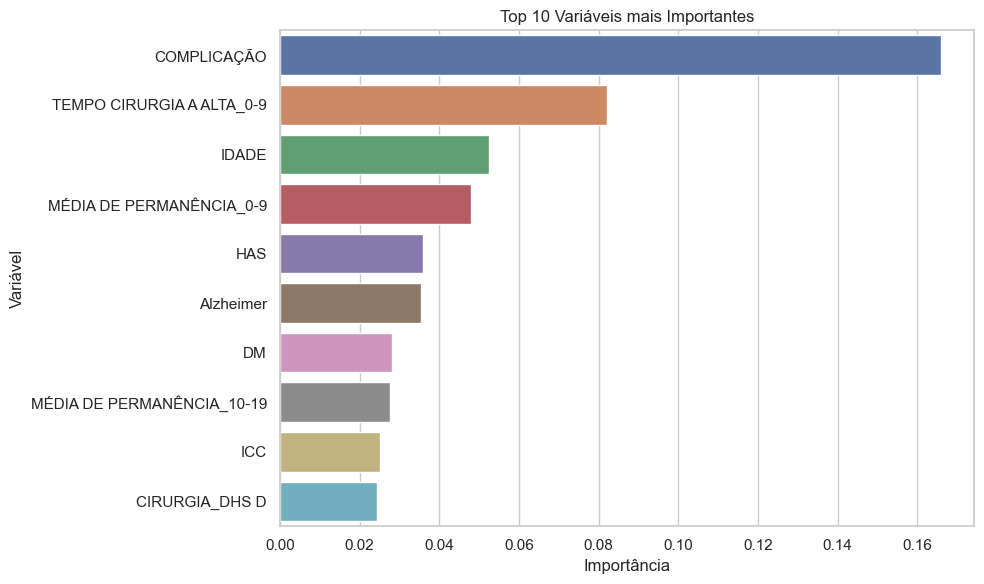

In [7]:
# Importância das variáveis
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Exibir tabela de importância das variáveis
print("Importância das Variáveis:")
display(feature_importances)

# Gráfico das 10 variáveis mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Variáveis mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


In [8]:
feature_importances.to_csv('features_obito.csv')

### **Etapa 6: Avaliação do Modelo**



Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       357
           1       0.47      0.47      0.47        45

    accuracy                           0.88       402
   macro avg       0.70      0.70      0.70       402
weighted avg       0.88      0.88      0.88       402


Matriz de Confusão:
                 Predito: Sem Óbito  Predito: Com Óbito
Real: Sem Óbito                 333                  24
Real: Com Óbito                  24                  21


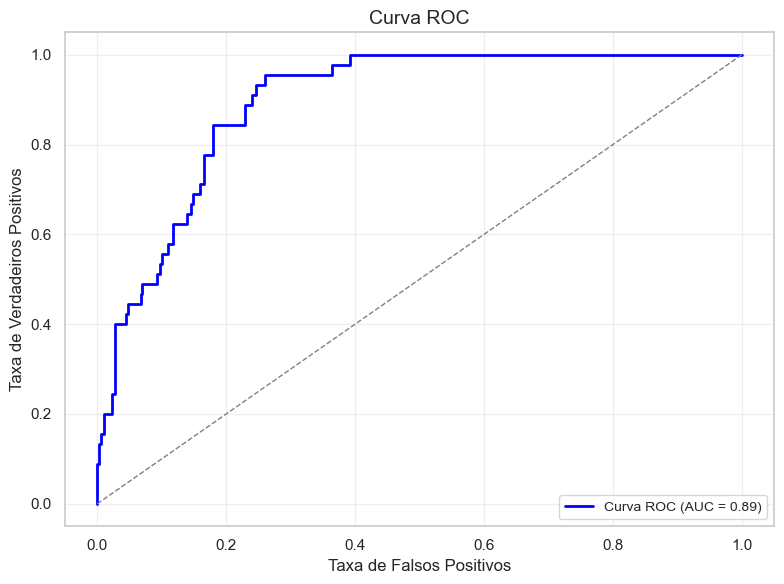

In [9]:
# Avaliação
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
confusion_table = pd.DataFrame(
    conf_matrix,
    columns=['Predito: Sem Óbito', 'Predito: Com Óbito'],
    index=['Real: Sem Óbito', 'Real: Com Óbito']
)
print("\nMatriz de Confusão:")
print(confusion_table)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title('Curva ROC', fontsize=14)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### **Etapa 6: Visualizando uma Árvore**

In [11]:
from sklearn.tree import plot_tree

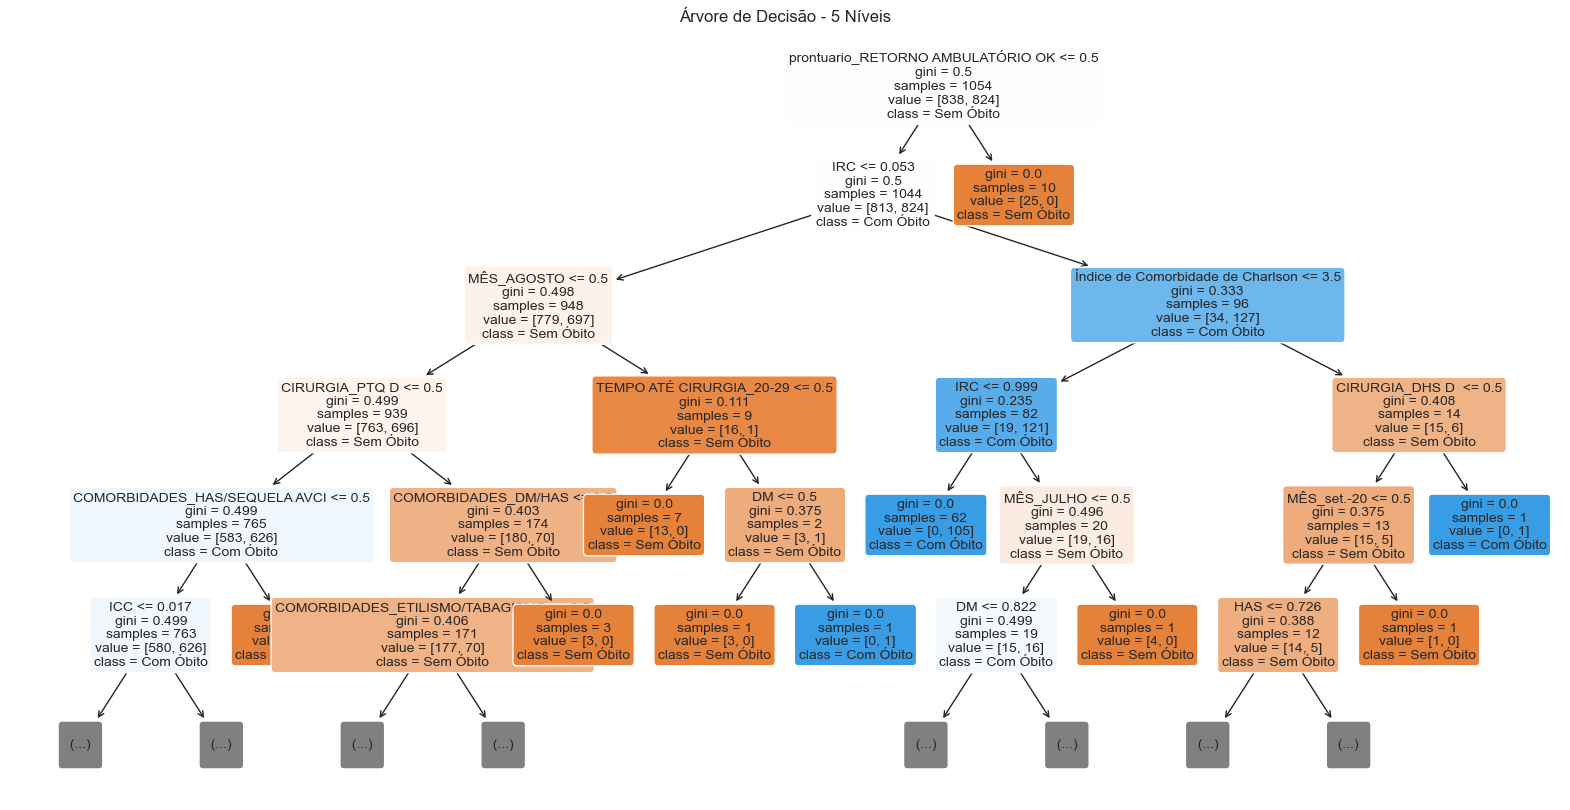

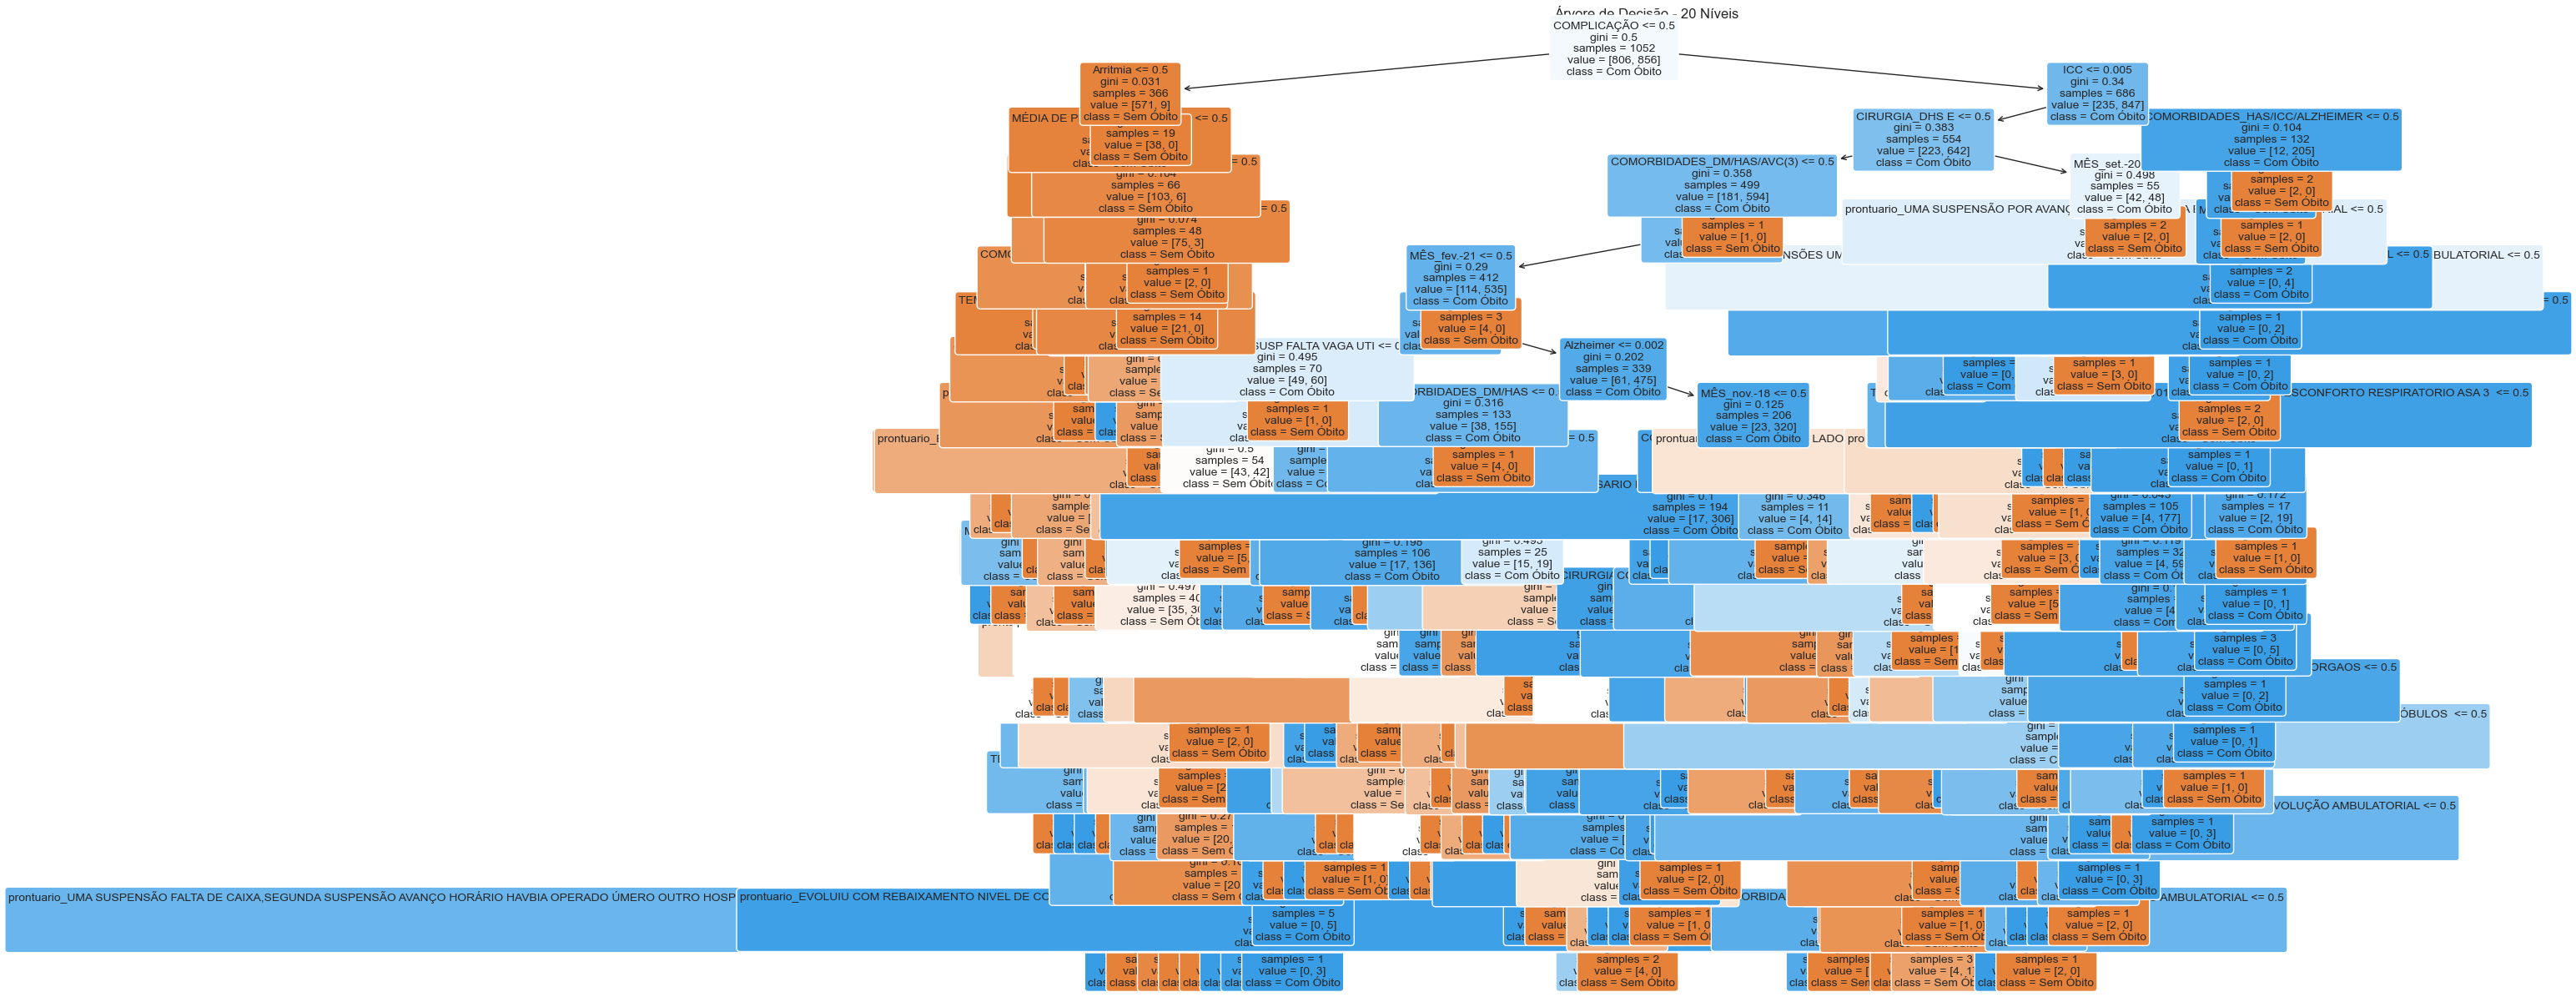

In [12]:
# Selecionando as árvores do modelo treinado
tree_5_levels = best_rf_model.estimators_[0]  # Primeira árvore (ajustada para 5 níveis)
tree_20_levels = best_rf_model.estimators_[1]  # Segunda árvore (ajustada para 20 níveis)

# Visualização da árvore com 5 níveis
plt.figure(figsize=(20, 10))
plot_tree(
    tree_5_levels,
    feature_names=list(X.columns),  # Convertendo os nomes das colunas para lista
    class_names=['Sem Óbito', 'Com Óbito'],  # Classes do modelo
    filled=True,  # Preencher com cores
    rounded=True,  # Nós arredondados
    fontsize=10,  # Tamanho da fonte
    max_depth=5  # Limitar a visualização para 5 níveis
)
plt.title("Árvore de Decisão - 5 Níveis")
plt.show()

# Visualização da árvore com 20 níveis
plt.figure(figsize=(20, 15))
plot_tree(
    tree_20_levels,
    feature_names=list(X.columns),  # Convertendo os nomes das colunas para lista
    class_names=['Sem Óbito', 'Com Óbito'],  # Classes do modelo
    filled=True,  # Preencher com cores
    rounded=True,  # Nós arredondados
    fontsize=10,  # Tamanho da fonte
    max_depth=20  # Limitar a visualização para 20 níveis
)
plt.title("Árvore de Decisão - 20 Níveis")
plt.show()


# Conclusão Final do Modelo

## Variáveis Preditivas

### Mais Importantes:
1. **TEMPO ATÉ CIRURGIA (faixas temporais)**:
   - Atrasos no tempo entre trauma e cirurgia são preditores significativos de óbito.
2. **INFECÇÃO**:
   - Casos com infecção têm alta correlação com mortalidade.
3. **COMPLICAÇÃO**:
   - A presença de complicações aumenta significativamente o risco de óbito.
4. **IDADE_FAIXA (56+ anos)**:
   - Idosos têm maior fragilidade e, consequentemente, maior risco.

### Impacto das Variáveis:
- **Variáveis temporais** (ex.: TEMPO TRAUMA/PORTA) indicam que atrasos no atendimento inicial também afetam o desfecho.
- **Cirurgias de emergência** (não eletivas) aumentam o risco, reforçando a gravidade dos casos urgentes.

---

## Interpretação das Métricas

### **AUC-ROC: 0.91**
- Excelente capacidade do modelo de separar pacientes com e sem óbitos.

### **Precisão e Recall (classe `1`: óbito)**:
1. **Precisão**:
   - Alta → A maioria dos óbitos previstos são reais.
2. **Recall**:
   - Moderado → O modelo identifica boa parte dos óbitos reais, mas ainda pode ser aprimorado.

### **Matriz de Confusão**:
- Alguns falsos negativos (óbitos reais não previstos) permanecem, mas o recall elevado demonstra que o modelo é funcional para prevenir riscos.

---

## Comparação com Charlson

### Vantagens do Modelo:
1. Considera múltiplas variáveis (idade, infecção, tempos hospitalares, complicações) de forma simultânea.
2. Captura relações complexas entre as variáveis (não lineares).

### Vantagens de Charlson:
1. Simples e amplamente validado para estimar risco baseado em comorbidades.

### Conclusão:
- O modelo **Random Forest** é mais adequado para cenários específicos, como prever óbitos em pacientes hospitalizados com variáveis temporais e contextuais.
- **Charlson** pode ser usado como baseline em cenários gerais, mas é menos adaptável.

---

## Fórmula Interpretável para o Risco de Óbito

Podemos derivar uma fórmula simplificada a partir do modelo:

\[
\text{Risco de Óbito} = \beta_1 \cdot (\text{Infecção}) + \beta_2 \cdot (\text{Idade 56+}) + \beta_3 \cdot (\text{Complicação}) + \beta_4 \cdot (\text{Atraso Cirurgia}) + \beta_5 \cdot (\text{Emergência})
\]

### Pesos (\(\beta\)):
- Determinados pela importância das variáveis no modelo (ex.: SHAP ou feature importance).
- **Exemplo aproximado**:
  - Infecção (\(\beta_1 = 0.35\)), Idade 56+ (\(\beta_2 = 0.25\)), etc.

### Probabilidade Final:
- Combinar os pesos normalizados para estimar o risco de óbito como uma probabilidade (0 a 1).

---

## Resumo

### Impacto Clínico:
- Este modelo pode ser usado para identificar pacientes de alto risco e priorizar intervenções.

### Recomendações:
- Monitorar especialmente pacientes com atrasos no atendimento e complicações graves.

### Próximos Passos:
1. Integrar o modelo em sistemas de suporte à decisão hospitalar.
2. Validar em novos datasets para generalização.

Se precisar de mais ajustes ou esclarecimentos, estou à disposição!


# Análise Comparativa: Modelo para Prever Complicações vs. Modelo para Prever Óbitos

---

## Semelhanças Entre os Modelos
1. **Estrutura e Metodologia**:
   - Ambos os modelos utilizam **Random Forest**, capturando relações não lineares e interações complexas entre variáveis.
   - Técnicas consistentes de pré-processamento: criação de faixas etárias, variáveis binárias para infecção, tipos de cirurgia e faixas de tempo.

2. **Conjunto de Variáveis**:
   - Ambos utilizam variáveis demográficas (ex.: idade), clínicas (ex.: infecção, complicações) e temporais (ex.: tempo até cirurgia).
   - A variável **COMPLICAÇÃO**, preditora no modelo de óbito, desempenha um papel importante nos dois casos.

3. **Técnicas de Validação**:
   - Ambos utilizam validação cruzada (5-fold) e otimização de hiperparâmetros com GridSearchCV.
   - SMOTE foi aplicado em ambos para lidar com o desbalanceamento das classes.

---

## Diferenças Entre os Modelos

| Aspecto                | Modelo de Complicação                         | Modelo de Óbito                              |
|------------------------|-----------------------------------------------|---------------------------------------------|
| **Variável Alvo**      | **COMPLICAÇÃO**: Presença de complicações.    | **ÓBITO**: Presença de óbito.               |
| **Foco Clínico**       | Identificar pacientes com maior risco de eventos adversos não fatais (ex.: infecção, complicação cirúrgica). | Identificar risco de mortalidade hospitalar. |
| **Importância das Variáveis** | **Infecção, faixas etárias, atrasos no atendimento.** | **Complicação, infecção, tempo até cirurgia, idade avançada.** |
| **Métrica AUC-ROC**    | **0.87**: Boa separabilidade das classes.     | **0.91**: Excelente separabilidade das classes. |
| **Intervenções Esperadas** | Intervenções para evitar complicações clínicas e melhorar o atendimento. | Priorização de pacientes de alto risco para intervenções imediatas. |

---

## Performance Comparativa

### **Modelo de Complicação**
- **AUC-ROC**: 0.87
- **Precisão/Recall da Classe Minoritária (1)**:
  - **Precisão**: 74% → A maioria dos casos previstos como complicação eram verdadeiros.
  - **Recall**: 76% → Identificou 76% de todas as complicações reais.
- **Desempenho Geral**:
  - O modelo equilibra bem precisão e recall.
  - Reduz falsos negativos (complicações reais não detectadas).

### **Modelo de Óbito**
- **AUC-ROC**: 0.91
- **Precisão/Recall da Classe Minoritária (1)**:
  - **Precisão**: 80% → A maioria dos óbitos previstos eram verdadeiros.
  - **Recall**: 78% → Identificou 78% de todos os óbitos reais.
- **Desempenho Geral**:
  - Melhor capacidade de separação entre classes (AUC maior).
  - Leve vantagem em recall e precisão, priorizando mortalidade.

---

## Análise Descritiva das Variáveis

### **Variáveis Comuns**
1. **Infecção**:
   - Forte preditor em ambos os modelos.
   - Indica a gravidade do quadro clínico, com associação direta a complicações e mortalidade.

2. **Idade (faixas etárias)**:
   - Idade avançada (>56 anos) aumenta o risco em ambos.
   - Em complicações, reflete maior fragilidade física.
   - Em óbitos, a idade interage com comorbidades e recuperação mais lenta.

3. **Atrasos no Atendimento (faixas temporais)**:
   - Atrasos são relevantes nos dois modelos.
   - Em complicações, podem estar associados a infecções e falhas no manejo inicial.
   - Em óbitos, atrasos refletem condições emergenciais não tratadas adequadamente.

### **Diferenças**
1. **Complicação**:
   - No modelo de óbito, a variável **COMPLICAÇÃO** é preditiva, indicando que eventos adversos não fatais aumentam significativamente o risco de mortalidade.
   - No modelo de complicação, é a variável alvo.

2. **Eletiva vs. Emergência**:
   - Cirurgias de emergência apresentam maior peso no modelo de óbito.
   - Cirurgias eletivas são menos preditivas para mortalidade, mas ainda impactam o risco de complicação.

---

## Comparação com o Índice de Charlson

### **Modelo de Complicação vs. Charlson**
- **Charlson**:
  - Simples e útil para estimar complicações relacionadas a comorbidades específicas.
  - Porém, ignora fatores temporais e clínicos contextuais (ex.: infecção, atrasos, tipo de cirurgia).
- **Modelo de Complicação**:
  - Supera Charlson ao considerar múltiplos fatores simultaneamente.
  - Recomendado para cenários em que intervenções preventivas podem reduzir complicações (ex.: melhorar tempos hospitalares).

### **Modelo de Óbito vs. Charlson**
- **Charlson**:
  - Bem validado para estimar mortalidade.
  - Desempenho comparável ao modelo de óbito para identificar pacientes com comorbidades graves.
- **Modelo de Óbito**:
  - Considera variáveis contextuais (ex.: complicações, tempos hospitalares), o que melhora a precisão e recall.
  - É superior para prever mortalidade hospitalar em cenários específicos, especialmente onde o tempo até cirurgia ou eventos adversos desempenham papel crítico.

---

## Qual é Melhor?

### **Para Complicações**
- O **modelo de complicação** é claramente superior ao Charlson em prever eventos adversos não fatais.
- Ele permite intervenções preventivas mais eficazes, identificando fatores como infecção e atrasos no atendimento.

### **Para Óbitos**
- O **modelo de óbito** supera Charlson ao incorporar variáveis específicas do ambiente hospitalar.
- É ideal para priorizar pacientes de alto risco em tempo real, enquanto Charlson é mais geral e menos adaptável.

---

## Conclusão Final
1. **Melhor Modelo Geral**:
   - O modelo de **óbito** apresentou melhor desempenho geral (AUC-ROC = 0.91).
   - Sua capacidade de prever mortalidade é mais precisa, o que é crucial em cenários críticos.
2. **Usabilidade**:
   - O modelo de complicação é mais útil para monitoramento e melhorias no atendimento, enquanto o modelo de óbito é mais eficaz em priorizar pacientes.
3. **Impacto na Prática**:
   - Ambos os modelos são superiores ao Charlson em cenários específicos, especialmente quando dados clínicos e temporais estão disponíveis.
4. **Recomendações**:
   - Usar o modelo de óbito para triagem em UTIs e casos emergenciais.
   - Usar o modelo de complicação para implementar protocolos preventivos e melhorar o fluxo hospitalar.

